In [1]:
from zipfile import ZipFile
import pandas as pd
import re
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn import svm, datasets
from sklearn.model_selection import cross_val_score
from sklearn.metrics import explained_variance_score

In [2]:
with ZipFile('dataset_diabetes.zip') as zf:
    with zf.open("dataset_diabetes/diabetic_data.csv") as f:
        df= pd.read_csv(f)
    #with zf.open('dataset_diabetes/IDs_mapping.csv') as f2:
    #    ids=pd.read_csv(f2)

In [3]:
#q1
df["count"] = df["encounter_id"].astype(str)+ df["patient_nbr"].astype(str)
count=df['count'].apply(lambda x: pd.Series(list(x)))
df["count"]=count.astype(float).sum(axis=1)
df['type'] = df['count'].apply(lambda x: 'train' if x%2==0 else 'test')
train=df[df["type"]=="train"]
train=train.drop(['count',"type"], 1)
test=df[df["type"]=="test"]
test=test.drop(['count',"type"], 1)
train.shape, test.shape

((50803, 50), (50963, 50))

In [4]:
#q2
(
    train["time_in_hospital"].mean(),
    test["time_in_hospital"].mean(),
    train["time_in_hospital"].std(), 
    test["time_in_hospital"].std(),
)


(4.401295199102416, 4.390695210250574, 2.984025665505041, 2.9862059667206435)

In [5]:
#q3
{
    "train": dict(train["readmitted"].value_counts()),
    "test": dict(test["readmitted"].value_counts()),
}

{'train': {'NO': 27360, '>30': 17770, '<30': 5673},
 'test': {'NO': 27504, '>30': 17775, '<30': 5684}}

In [6]:
#q4

count={}
for i in train:
    c=np.sum(train[i] =="?")
    if c==0:
        continue
    else:
        count[i]=(c/train.shape[0])*100
    
count

/home/ydong66/.local/lib/python3.6/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


{'race': 2.2104993799578763,
 'weight': 96.80924354860933,
 'payer_code': 39.25949254965258,
 'medical_specialty': 49.180166525598885,
 'diag_1': 0.023620652323681674,
 'diag_2': 0.3444678463870244,
 'diag_3': 1.3955868747908586}

In [7]:
def check_regression(ax):
    plot = {}
    plot["font12plus"] = min(ax.xaxis.label.get_size(),
                             ax.yaxis.label.get_size(),
                             ax.get_xticklabels()[0].get_size()) >= 12
    plot["transparency"] = ax.collections[0].get_alpha() != None
    plot["x-label"] = ax.get_xlabel().lower()
    plot["y-label"] = ax.get_ylabel().lower()
    plot["spines"] = ax.spines['right'].get_visible() or ax.spines['top'].get_visible()
    plot["x-mean"], plot["y-mean"] = ax.collections[0].get_offsets().data.std(axis=0)
    plot["x-std"], plot["y-std"] = ax.collections[0].get_offsets().data.mean(axis=0)
    plot["slope"] = None
    for line in ax.get_lines():
        x = line.get_xdata()
        y = line.get_ydata()
        for i in range(1, len(x)):
            slope = (y[i]-y[i-1]) / (x[i] - x[i-1])
            intercept = y[i] - x[i] * slope
            if plot["slope"] is None:
                plot["slope"] = slope
                plot["intercept"] = intercept
            elif not (np.isclose(plot["slope"], slope) and 
                      np.isclose(plot["intercept"], intercept)):
                plot["slope"] = None
                plot["intercept"] = None
                break
    return plot

{'font12plus': True,
 'transparency': True,
 'x-label': 'visits',
 'y-label': 'days in hospital',
 'spines': False,
 'x-mean': 2.2887866256900424,
 'y-mean': 2.983996296763971,
 'x-std': 1.206208294785741,
 'y-std': 4.401295199102416,
 'slope': 0.03951032525517387,
 'intercept': 4.353637517049943}

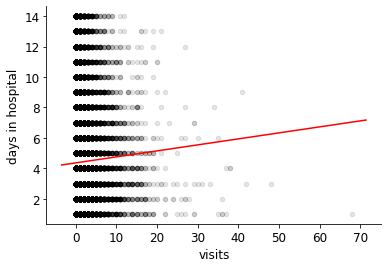

In [8]:
#q8
train["visits"]=train["number_outpatient"]+train["number_inpatient"]+train["number_emergency"]
x=train['visits'].to_list()
y=train['time_in_hospital'].to_list()
x=np.asarray(x, dtype=np.float64).reshape(-1, 1)
y=np.asarray(y, dtype=np.float64).reshape(-1, 1)
ax = train.plot.scatter(x="visits",y="time_in_hospital",color="black", fontsize=12, alpha=0.1)
reg = LinearRegression().fit(x, y)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("visits",fontsize=12)
ax.set_ylabel("days in hospital",fontsize=12)
ax.plot(ax.get_xlim(), [float(reg.coef_[0])*ax.get_xlim()[0]+ float(reg.intercept_), float(reg.coef_[0])*ax.get_xlim()[1]+ float(reg.intercept_)], c="r")
check_regression(ax)

In [9]:
#q9
train_=explained_variance_score(y, x*float(reg.coef_[0])+ float(reg.intercept_))
test["visits"]=test["number_outpatient"]+test["number_inpatient"]+test["number_emergency"]
x=test['visits'].to_list()
y=test['time_in_hospital'].to_list()
x=np.asarray(x, dtype=np.float64).reshape(-1, 1)
y=np.asarray(y, dtype=np.float64).reshape(-1, 1)
reg = LinearRegression().fit(x, y)
test_=explained_variance_score(y,reg.predict(x))
(train_,test_)

(0.0009184071670116367, 0.0010954269445123677)

{'font12plus': True,
 'transparency': True,
 'x-label': 'days in hospital',
 'y-label': 'lab procedures done',
 'spines': False,
 'x-mean': 2.983996296763971,
 'y-mean': 19.769919407825235,
 'x-std': 4.401295199102416,
 'y-std': 43.155915989213234,
 'slope': 2.119487878508591,
 'intercept': 33.8274241649776}

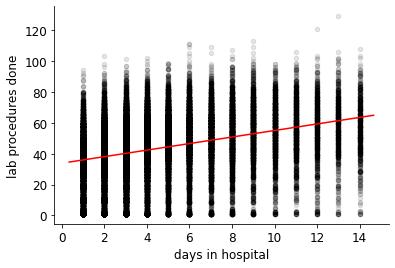

In [10]:
#q10
x=train['time_in_hospital'].to_list()
y=train['num_lab_procedures'].to_list()
x=np.asarray(x, dtype=np.float64).reshape(-1, 1)
y=np.asarray(y, dtype=np.float64).reshape(-1, 1)
ax = train.plot.scatter(x="time_in_hospital",y="num_lab_procedures",color="black", fontsize=12, alpha=0.1)
reg = LinearRegression().fit(x, y)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("days in hospital",fontsize=12)
ax.set_ylabel("lab procedures done",fontsize=12)
ax.plot(ax.get_xlim(), [float(reg.coef_[0])*ax.get_xlim()[0]+ float(reg.intercept_), float(reg.coef_[0])*ax.get_xlim()[1]+ float(reg.intercept_)], c="r")
check_regression(ax)

In [11]:
#q11
train_=explained_variance_score(y, x*float(reg.coef_[0])+ float(reg.intercept_))
x=test['time_in_hospital'].to_list()
y=test['num_lab_procedures'].to_list()
x=np.asarray(x, dtype=np.float64).reshape(-1, 1)
y=np.asarray(y, dtype=np.float64).reshape(-1, 1)
reg = LinearRegression().fit(x, y)
test_=explained_variance_score(y, x*float(reg.coef_[0])+ float(reg.intercept_))
(train_,test_)

(0.10234075960861977, 0.1004802491767921)

In [12]:
train["readmit_soon"] = train["readmitted"] == "<30"
test["readmit_soon"] = test["readmitted"] == "<30"

In [13]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.base import BaseEstimator, ClassifierMixin

In [44]:
#q15
x=train['readmit_soon']
y=train['time_in_hospital']
x=np.asarray(x, dtype=np.float64).reshape(-1, 1)
y=np.asarray(y, dtype=np.float64).reshape(-1, 1)
reg=LogisticRegression(solver="lbfgs")
reg.fit(y,x)
train_=accuracy_score(x,reg.predict(y))
x=test['readmit_soon'].to_list()
y=test['time_in_hospital'].to_list()
x=np.asarray(x, dtype=np.float64).reshape(-1, 1)
y=np.asarray(y, dtype=np.float64).reshape(-1, 1)
test_=accuracy_score(x,reg.predict(y))

(train_, test_)

/home/ydong66/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(0.8883333661397949, 0.8884681043109707)

In [39]:
#q16
class NaiveEstimator(BaseEstimator, ClassifierMixin):
    def fit(self, X, y):
        if y.sum() / len(y) > 0.5:
            self.prediction = True
        else:
            self.prediction = False

    def predict(self, X):
        return [self.prediction] * len(X)
x=train['readmit_soon'].to_list()
y=train['time_in_hospital'].to_list()
x=np.asarray(x, dtype=np.float64).reshape(-1, 1)
y=np.asarray(y, dtype=np.float64).reshape(-1, 1)
a=NaiveEstimator()
a.fit(y,x)
train_=accuracy_score(x,a.predict(y))

x=test['readmit_soon'].to_list()
y=test['time_in_hospital'].to_list()
x=np.asarray(x, dtype=np.float64).reshape(-1, 1)
y=np.asarray(y, dtype=np.float64).reshape(-1, 1)
test_=accuracy_score(x,a.predict(y))

(train_, test_)

(0.8883333661397949, 0.8884681043109707)

In [40]:
#q17
x=train['readmit_soon'].to_list()
y=train['time_in_hospital'].to_list()
x=np.asarray(x, dtype=np.float64).reshape(-1, 1)
y=np.asarray(y, dtype=np.float64).reshape(-1, 1)
reg=LogisticRegression(solver="lbfgs")
reg.fit(y, x)
train_=balanced_accuracy_score(x,reg.predict(y))
x=test['readmit_soon'].to_list()
y=test['time_in_hospital'].to_list()
x=np.asarray(x, dtype=np.float64).reshape(-1, 1)
y=np.asarray(y, dtype=np.float64).reshape(-1, 1)
test_=balanced_accuracy_score(x,reg.predict(y))

(train_, test_)

/home/ydong66/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(0.5, 0.5)

In [35]:
#q18
x=train['readmit_soon'].to_list()
y=train['time_in_hospital'].to_list()
x=np.asarray(x, dtype=np.float64).reshape(-1, 1)
y=np.asarray(y, dtype=np.float64).reshape(-1, 1)
reg=LogisticRegression(class_weight="balanced")
reg.fit(y,x)
train_=balanced_accuracy_score(x,reg.predict(y))

x=test['readmit_soon'].to_list()
y=test['time_in_hospital'].to_list()
x=np.asarray(x, dtype=np.float64).reshape(-1, 1)
y=np.asarray(y, dtype=np.float64).reshape(-1, 1)
test_=balanced_accuracy_score(x,reg.predict(y))

(train_, test_)

/home/ydong66/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(0.5332863335560872, 0.5292818798995528)

In [29]:
#q19
x=train['readmit_soon']
y=train[['time_in_hospital','num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient']]
reg=LogisticRegression(class_weight="balanced")
reg.fit(y,x)
train_=balanced_accuracy_score(x,reg.predict(y))

y_=test['readmit_soon']
x_=test[['time_in_hospital','num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient']]
test_=balanced_accuracy_score(y_,reg.predict(x_))
(train_, test_)

(0.5930123033331954, 0.5882354971931861)

1         False
4         False
6         False
7         False
9         False
          ...  
101754    False
101755    False
101756    False
101759    False
101762    False
Name: readmit_soon, Length: 50963, dtype: bool